<a href="https://colab.research.google.com/github/hkumar747/llm-json/blob/main/03_hf_mistral_finetune222.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parameter efficient fine-tuning Mistral-7b

### Quantized Low Rank Adaptation of Large Language Models (QLoRA)



This notebook walks through fine-tuning an open source LLM from HuggingFace, Mistral-7b using quantization and LoRA, two recent scientific breakthroughs which allow language models to be trained at a fraction of the compute cost.

The task is the same as in the first notebook with OpenAI, extracting information in JSON format from passages.




## Use case: We need a customized model for extracting structured data from permit notices.


In [1]:
#  !pip -q install git+https://github.com/huggingface/transformers # need to install from github
# https://blog.paperspace.com/mistral-7b-fine-tuning/

# !pip install transformers==4.35.2 trl langchain accelerate torch bitsandbytes peft datasets -qU
# !pip install -q datasets loralib sentencepiece xformers einops
!pip install -q -U peft==0.6.2 transformers==4.35.2 datasets==2.15.0 bitsandbytes==0.41.2.post2 trl==0.7.4 accelerate==0.24.1 wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.7/174.7 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.9/133.9 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 75.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

## Parameter Efficient Fine Tuning with LoRA


https://heidloff.net/article/efficient-fine-tuning-lora/

https://towardsdatascience.com/implementing-lora-from-scratch-20f838b046f1

`verbatim`
PEFT, or Parameter-Efficient Fine-Tuning (PEFT), is a library for efficiently adapting pre-trained language models to downstream applications without without the need to re-train or fine-tune all the parameters.

One main form of PEFT is Low Rank Adaptation (LoRA) of large language models, based on the concept of rank of matrices in linear algebra.

```
LoRA is a method for fine-tuning language models without altering the original model parameters. In practical fine-tuning tasks, a set of low-rank adapters is added alongside specific model layers to be trained. In the original paper, the adapters were only added to two attention layers. The output dimensions of these adapters match those of the original model layers exactly.

Subsequently, the adapters are set to be trainable, while the original model parameters are frozen and not allowed to be trained. This approach allows for the training of large language models without affecting inference speed significantly and only slightly increasing the parameter count.
```


"common pre-trained models have a very low intrinsic dimension; in other words, there exists a low dimension reparameterization that is as effective for fine-tuning as the full parameter space."
https://arxiv.org/abs/2012.13255


Instead of adjusting the entire weight matrix (which is part of the linear transformations in the model's layers), LoRA introduces additional low-rank matrices that modify the original weight matrices in a more parameter-efficient manner. This process allows for targeted adaptations that significantly alter the model's behavior


<img src="images/peft_heidloff.png" alt="Descriptive text about the image" width="600"/>

Source: [Niklas Heidloff](https://heidloff.net/article/efficient-fine-tuning-lora/)


**SVD and matrix rank**
https://sebastianraschka.com/blog/2023/llm-finetuning-lora.html
"The overall idea and concept are related to principal component analysis (PCA) and singular value decomposition (SVD), where we approximate a high-dimensional matrix or dataset using a lower-dimensional representation. In other words, we try to find a (linear) combination of a small number of dimensions in the original feature space (or matrix) that can capture most of the information in the dataset."

**Remember:** Large Language Models (LLMs) are simply lots of matrices (or tensors) of numbers.



**PEFT supported models**

HuggingFace has a list of 10 models for which LoRA adapters are available:
https://huggingface.co/docs/peft/index#supported-models




## Selecting a model


Look at the [HF leaderboard of open LLMS](https://huggingface.co/spaces/HuggingFaceH4/open_llm_leaderboard).

There are multiple benchmarks to score LLMs, each designed for different linguistic, reasoning or numeric tasks.


**Benchmarks:**


**1. ARC (AI2 Reasoning Challenge)**
ARC challenges models on grade-school level multiple-choice science questions. It's designed to test a model's reasoning and knowledge.


**2. HellaSwag**
HellaSwag is a benchmark for commonsense reasoning, predicting the endings of a given scenario in both textual and video contexts.


**3. MMLU (Massive Multitask Language Understanding)**
MMLU evaluates language models across a wide range of subjects and disciplines, testing the model's understanding on diverse topics.

**4. TruthfulQA**
This benchmark tests models on providing truthful answers, focusing on avoiding hallucinations and sticking to factual responses.


**5. Winogrande**
Winogrande is a dataset for commonsense reasoning, designed as an improved and scaled-up version of the Winograd Schema Challenge.


**6. GSM8K (Grade School Math 8K)**
GSM8K tests models on solving grade-school level math problems presented in textual form.


Without admittedly delving too deep into it (maybe one of the above benchmarks has JSON tasks), common-sense reasoning would say TruthfulQA is the most relevant benchmark for this task. It mostly doesn't require any external knowledge of the world (caveat: impacts on wetland), just the ability to not hallucinate or be inaccurate when it transcribes from the text to the dictionary.

In any case, we will be fine-tuning the Mistral-7b model.

The following resources are helpful for understanding this notebook:

- [Mistral](https://www.datacamp.com/tutorial/mistral-7b-tutorial)

- [Mixtral](https://github.com/brevdev/notebooks/blob/main/mixtral-finetune-own-data.ipynb)

- [huggingFace Transformers Training](https://huggingface.co/docs/transformers/en/training)


### Weights & Biases for tracking metrics

Use Weights & Biases to track training metrics. Enter your API key when prompted.

In [2]:
!pip install -q wandb -U

import wandb, os
wandb.login()

wandb_project = "mistral-7b-usace-finetune_v2"
os.environ["WANDB_PROJECT"] = wandb_project

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Load training dataset

It just needs to be a dataset of input-output pairs. The phrase 'supervised fine tuning' signals an image of a dataset of (vectors) of inputs and output, as in supervised learning. But that would be misleading - here the Xs and Ys are concatenated together into strings of continuous tokens, interspersed with special tokens which marks inputs and outputs.

Basically, the dataset consists of input-output pairs like:

**Input**
>The applicant seeks author ization to construct a single-family residence on the 2.09-acre parcel, including the permanent fill and loss of  0.78 acres of mangrove wetlands.


**Output**
>

>>{'wetlands': [
>  {'**wetland_type**': 'mangrove wetlands',

> >  '**impact_quantity**': 0.78,

 > > '**impact_unit**': 'acres',

  > >'**impact_type**': 'fill',
   
   >> '**impact_duration**': 'permanent'}]}
>



In [ ]:
from datasets import load_dataset

instruct_tune_dataset = load_dataset("mosaicml/instruct-v3")
instruct_tune_dataset

type(instruct_tune_dataset)

instruct_tune_dataset['train']


### Convert from OpenAI JSONL to HuggingFace Dataset

https://huggingface.co/transformers/v3.2.0/custom_datasets.html


Load the JSONL file of verified input-output pairs we used in notebook 2. (This step assumes you've already connverted them into JSONL format for OpenAI.) The following step will convert these into a format suitable for HuggingFace.

In [4]:
from datasets import Dataset
from pathlib import Path
import json
def load_jsonl_to_dataset(jsonl_file_path):
    # Initialize lists to hold the values for each field
    system_messages = []
    user_messages = []
    assistant_messages = []

    # Open and read the JSONL file
    with open(jsonl_file_path, 'r', encoding='utf-8') as file:
        for line in file:
            data = json.loads(line)
            system_msg = user_msg = assistant_msg = None  # Reset for each entry

            # Iterate over messages and extract content based on role
            for message in data['messages']:
                if message['role'] == 'system':
                    system_msg = message['content']
                elif message['role'] == 'user':
                    user_msg = message['content']
                elif message['role'] == 'assistant':
                    assistant_msg = message['content']

            # Append messages to their respective lists
            system_messages.append(system_msg)
            user_messages.append(user_msg)
            assistant_messages.append(assistant_msg)

    # Construct a dictionary with these lists
    data_dict = {
        'system': system_messages,
        'user': user_messages,
        'assistant': assistant_messages
    }

    # Convert the dictionary to a Hugging Face Dataset
    dataset = Dataset.from_dict(data_dict)

    return dataset


train_dataset = load_jsonl_to_dataset("usace_finetune_training.jsonl")
val_dataset = load_jsonl_to_dataset("usace_finetune_validation.jsonl")

# Displaying the structure of the train dataset as an example
print(f"Train Dataset:\n{train_dataset}")

Train Dataset:
Dataset({
    features: ['system', 'user', 'assistant'],
    num_rows: 88
})


#### Instruction:

In [4]:
train_dataset[5]['system']


'\n"Task: Extract information from a project description to create a structured dictionary, following the provided JSON schema. Focus on identifying wetland impacts based on the given criteria.\n\nJSON Schema Overview:\n\nwetland_type: Type or descriptor of the wetland (e.g., swamp, marsh).\nimpact_quantity: Numeric value of the impacted area.\nimpact_unit: Units of measurement (acres, sq. feet, linear feet).\nimpact_duration: Duration of impact (permanent, temporary, unknown).\nimpact_type: Nature of impact (harmful, beneficial, unknown).\nInstructions:\n\nIdentify Wetlands and Impacts: Look for sentences detailing the wetland type and area impacted. Record the type, quantity, and unit.\nDetermine Impact Duration: Mark \'permanent\' or \'temporary\' if mentioned with wetland type and area; else, write \'unknown\'.\nAssess Impact Type: Identify if the impact is harmful, beneficial, or unknown.\nAvoid Double Counting: Be mindful of nested projects or phrases indicating multiple projects

#### Input:

In [5]:
train_dataset[5]['user']

'Project Description: Clear, grade, excavate, and fill to construct a cemetery and funeral home.This project would require permanent impacts to 6.58 acres of forested palustrine wetlands. The applicant proposes to purchase credits from a mitigation bank to offset any unavoidable losses to wetland functions caused by project implementation.This is a second public notice due to changes in the project plans resulting in more wetland impacts than previously proposed.\n\nExtracted Data: '

#### Output

In [6]:

train_dataset[5]['assistant']

"{'wetlands': [{'wetland_type': 'forested palustrine wetlands', 'impact_quantity': '6.58', 'impact_unit': 'acres', 'impact_duration': 'permanent', 'impact_type': 'loss'}]}"

### Prompt formatting function

Change the prompt and output to the format specified for Mistral-7b - particularly, note the beginning of string (bos) and end of string (eos) special tokens.

In [5]:
def create_prompt(sample):
    bos_token = "<s>"
    eos_token = "</s>"

    # Directly access the 'system', 'user', and 'assistant' messages from the sample
    system_message = sample['system'].replace("\n", " ").strip()
    user_message = sample['user'].replace("\n", " ").strip()
    assistant_message = sample['assistant'].replace("\n", " ").strip()

    # Concatenate the prompt according to the specified format
    full_prompt = f"{bos_token}"
    full_prompt += f"### Instruction: \n{system_message}"
    full_prompt += f"\n\n### Input:\n{user_message}"
    full_prompt += f"\n\n### Response:\n{assistant_message}"
    full_prompt += f"{eos_token}"

    return full_prompt
create_prompt(train_dataset[5])


'<s>### Instruction: \n"Task: Extract information from a project description to create a structured dictionary, following the provided JSON schema. Focus on identifying wetland impacts based on the given criteria.  JSON Schema Overview:  wetland_type: Type or descriptor of the wetland (e.g., swamp, marsh). impact_quantity: Numeric value of the impacted area. impact_unit: Units of measurement (acres, sq. feet, linear feet). impact_duration: Duration of impact (permanent, temporary, unknown). impact_type: Nature of impact (harmful, beneficial, unknown). Instructions:  Identify Wetlands and Impacts: Look for sentences detailing the wetland type and area impacted. Record the type, quantity, and unit. Determine Impact Duration: Mark \'permanent\' or \'temporary\' if mentioned with wetland type and area; else, write \'unknown\'. Assess Impact Type: Identify if the impact is harmful, beneficial, or unknown. Avoid Double Counting: Be mindful of nested projects or phrases indicating multiple pr

## Load and Train the Model

https://blog.paperspace.com/mistral-7b-fine-tuning/

## Quantized LoRA (QLoRA)

QLoRA by Dettmers et al., short for quantized LoRA, is a technique that reduces memory usage during finetuning. During backpropagation, QLoRA **quantizes** the pretrained weights to 4-bit precision and uses **paged optimizers** to handle memory spikes.

**Democratization of AI**
verbatim "Traditionally, fine-tuning LLMs requires significant computing power and hardware resources, often inaccessible to researchers and smaller institutions. QLoRA bypasses this barrier by leveraging quantization, a process that reduces the size and complexity of LLM parameters. This makes fine-tuning more accessible and resource-efficient."https://wandb.ai/sauravmaheshkar/QLoRA/reports/What-is-QLoRA---Vmlldzo2MTI2OTc5


This author found he saved 33% of GPU memory when using QLoRA, at a cost of 39% increased training runtime. This is caused by the additional quantization/dequantization steps of the pretrained model weights in QLoRA.

Note: Its preferred to use BFloat16, but it wasn't supported on a V100 GPU on Colab, so I worked around this.

https://brev.dev/blog/how-qlora-works




![image](qlora.png)

### Key idea: 4-Bit Normal Float
4-bit NormalFloat or NF is a new information-theoretically optimal data type built on top of Quantile Quantization techniques. 4-Bit NF works by estimating the 2k + 1 (k is the number of bits) quantiles in a 0 to 1 distribution, then normalizing its values into the [-1, 1] range. Once we have that, we can also normalize our neural network weights into the [-1, 1] range and then quantize into the quantiles we got from step 2.

‍https://www.mercity.ai/blog-post/guide-to-fine-tuning-llms-with-lora-and-qlora

In [7]:
import torch
import transformers, accelerate, bitsandbytes
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

# torch.set_default_device('cuda')

# set quantization config
nf4_config = BitsAndBytesConfig(
   load_in_4bit=True,
   bnb_4bit_quant_type="nf4",
   bnb_4bit_use_double_quant=True,
  #  bnb_4bit_compute_dtype=torch.bfloat16
)

#select model
model_name = "mistralai/Mistral-7B-Instruct-v0.1"

# "stabilityai/stablelm-3b-4e1t" - No quantization?

# 'EleutherAI/gpt-neo-1.3B'

model = AutoModelForCausalLM.from_pretrained(model_name,
                                              device_map='auto',
                                              # load_in_4bit=True,
                                              quantization_config=nf4_config,
                                              use_cache=False)

tokenizer = AutoTokenizer.from_pretrained(model_name)
    #    padding_side="left",
    # add_eos_token=True,
    # add_bos_token=True,

tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Step 3: Tokenization and padding

Before training, you need to tokenize your dataset. The tokenizer will convert your text into a format that's suitable for the model to process:


**Newline Characters**

- When tokenizing text, newline characters are treated as whitespace and are used to separate tokens. For many models, especially those trained on a wide variety of internet text (like GPT, BERT, etc.), encountering newline characters is expected and won't cause issues.

- For some tasks, newline characters might carry semantic meaning (e.g., separating paragraphs or items in a list), which could be relevant for the model to understand the structure of the input text.


**Note:** Padding - affects compute requirements

In [15]:

token = ""

# set max length of sequence
max_length=968


tokenizer.pad_token = tokenizer.eos_token

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(train_dataset["user"],
                     max_length=max_length,padding="max_length", truncation=True)

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
# tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/88 [00:00<?, ? examples/s]

### Plot a histogram of the distribution of tokens

The red vertical line at x = 968 is the `max_length`. Shorter passages are padded with `eos_tokens` and longer passages are split.

88


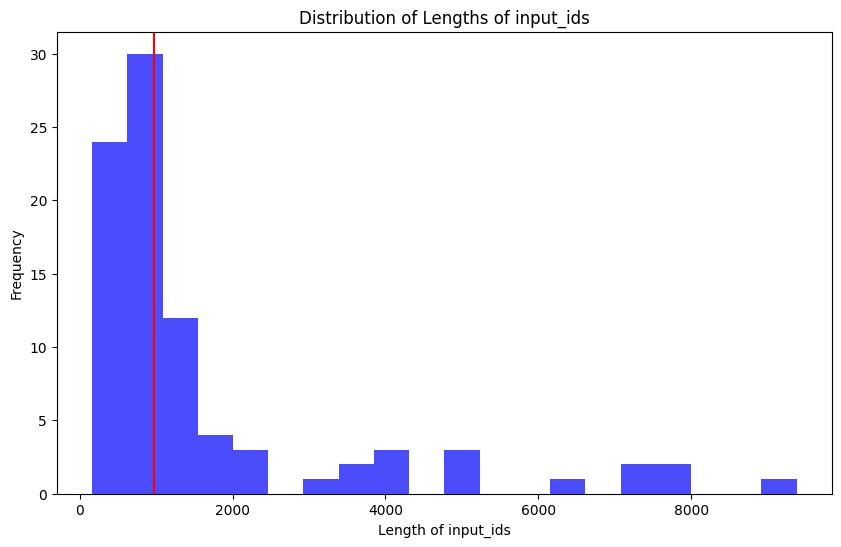

In [24]:
import matplotlib.pyplot as plt


def plot_data_lengths(tokenized_train_dataset):
    lengths = [len(x['user']) for x in tokenized_train_dataset]
    # lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.axvline(x=968, color='red')
    plt.show()
plot_data_lengths(tokenized_train_dataset)


## Set LoRA Configuration


Choose the particular layers you want to fine tune - the more layers, the more the compute cost and training time, maybe for negligibly higher performance.

As mentioned above, the original paper chose the $Q$ and $V$ layers of the attention mechanism.

`r` = rank of the low-rank matrix used in the adapters. Changes the number of parameters trained. In the extreme, full rank would mean full fine-tuning

`alpha` = scaling factor for the learned weights. The weight matrix is scaled by alpha/r, and thus a higher value for alpha assigns more weight to the LoRA activations.

The values used in the QLoRA paper were `r=64` and `lora_alpha=16`.

In [8]:
from peft import LoraConfig, get_peft_model

peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.08,
    r=64,
    target_modules=["q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
    #     "w1",
    #     "w2",
    #     "w3",
    #     "lm_head",
    ],
    bias="none",
    task_type="CAUSAL_LM"
)

In [9]:
## prepare model for kbit training
from peft import prepare_model_for_kbit_training


model = prepare_model_for_kbit_training(model)

# model.to('cuda')

In [18]:
model.device

device(type='cuda', index=0)

In [27]:
# ONLY RUN this step to see the model - introduces errors

model_print = get_peft_model(model, peft_config)
model_print

In [28]:
"""

The output of the above cell is like:

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralAttention(
              (q_proj): Linear4bit(
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.08, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
              )
              (k_proj): Linear4bit(
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.08, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=1024, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (base_layer): Linear4bit(in_features=4096, out_features=1024, bias=False)
              )
              (v_proj): Linear4bit(
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.08, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=1024, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (base_layer): Linear4bit(in_features=4096, out_features=1024, bias=False)
              )
              (o_proj): Linear4bit(
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.08, inplace=False)
                  ...
                  ...
 """

### How many trainable parameters?

Approx. 54.5 million out of ~7.2 billion (0.74 %)

In [30]:
model_print.print_trainable_parameters()

trainable params: 54,525,952 || all params: 7,296,258,048 || trainable%: 0.7473139195638273


### Training hyperparameters


Use the `transformers` trainer. Full list of parameter [here](https://github.com/huggingface/transformers/blob/v4.15.0/src/transformers/training_args.py#L73)

In [10]:
from transformers import TrainingArguments
args = TrainingArguments(
  output_dir = "mistral_instruct_generation",
  #num_train_epochs=5,
  max_steps = 200,
  per_device_train_batch_size = 1,
  gradient_accumulation_steps = 4,
  # gradient_checkpointing = True,
  fp16 = True,
  # gradient_checkpointing_steps = 10,
  warmup_steps = 0.03,
  logging_steps=10,
  save_strategy="epoch",
  #evaluation_strategy="epoch",
  evaluation_strategy="steps",
  eval_steps=40,
  learning_rate=2e-4,
  bf16=False,
  lr_scheduler_type='constant',
)

## Train the Model


Use the huggingface `trl` module.



In [11]:
from trl import SFTTrainer

max_seq_length = 968

trainer = SFTTrainer(
  model=model,
  peft_config=peft_config,
  max_seq_length=max_seq_length,
  tokenizer=tokenizer,
  packing=True,
  formatting_func=create_prompt,
  args=args,
  dataset_text_field="text",
  train_dataset=train_dataset,
  eval_dataset= val_dataset,
  # instruct_tune_dataset["test"]
)

/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_config.py:141: UserWarning: The `optimize_cuda_cache` arguement will be deprecated soon, please use `optimize_device_cache` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:548: UserWarning: The passed formatting_func has more than one argument. Usually that function should have a single argument `example` which corresponds to the dictionary returned by each element of the dataset. Make sure you know what you are doing.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:267: UserWarning: You passed `packing=True` to the SFTTrainer, and you are training your model with `max_steps` strategy. The dataset will be iterated until the `max_steps` are reached.
  warnings.warn(


In [12]:
import time
start = time.time()
trainer.train()
print(time.time()- start)

wandb: Currently logged in as: hk939. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:570: UserWarning: The dataset reached end and the iterator is reset to the start.
  warnings.warn("The dataset reached end and the iterator is reset to the start.")
You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/bitsandbytes/nn/modules.py:226: UserWarning: Input t

Step,Training Loss,Validation Loss
40,0.822100,1.051784
80,0.552500,1.016987
120,0.473900,1.034781
160,0.441400,1.101457
200,0.287300,1.133823


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:643: UserWarning: Length of IterableDataset <trl.trainer.utils.ConstantLengthDataset object at 0x7d77b5d112d0> was reported to be 88 (when accessing len(dataloader)), but 89 samples have been fetched. 
  warnings.warn(warn_msg)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:643: UserWarning: Length of IterableDataset <trl.trainer.utils.ConstantLengthDataset object at 0x7d77b5d112d0> was reported to be 88 (when accessing len(dataloader)), but 90 samples have been fetched. 
  warnings.warn(warn_msg)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:643: UserWarning: Length of IterableDataset <trl.trainer.utils.ConstantLengthDataset object at 0x7d77b5d112d0> was reported to be 88 (when accessing len(dataloader)), but 91 samples have been fetched. 
  warnings.warn(warn_msg)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:643: UserWarning: Length of Iter

1086.7619116306305


### Save trained model.

In [13]:
# save model
trainer.model.save_pretrained("mistral_ft_8mar")
wandb.finish()
model.config.use_cache = True

eval/loss,▃▁▂▆█
eval/runtime,██▄▄▁
eval/samples_per_second,▁▁▅▅█
eval/steps_per_second,▁▁▅▅█
train/epoch,▁▁▂▂▂▂▃▃▄▄▄▄▅▅▅▅▆▆▇▇▇▇████
train/global_step,▁▁▂▂▂▂▃▃▄▄▄▄▅▅▅▅▆▆▇▇▇▇████
train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,█▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


## Inference

In [14]:
# logging.set_verbosity(logging.CRITICAL)
from transformers import pipeline
prompt = "Extract to JSON: The applicant has requested Department of the Army authorization to clear, grade and fill in order to expand an ex isting sand and gravel mining operation in Grangeville, Louisian a.The proposed sand and gra vel pits will encompass approximately 56.5 acres and will be dug to adepth of 35 feet with 3:1 side slopes. It is anticipated that the proposed activity will impact approximately 1.47 acres of forested wetlands."
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=600)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<s>[INST] Extract to JSON: The applicant has requested Department of the Army authorization to clear, grade and fill in order to expand an ex isting sand and gravel mining operation in Grangeville, Louisian a.The proposed sand and gra vel pits will encompass approximately 56.5 ac res and will be dug to adepth of 35 feet with 3:1 side slopes.Approximately 47,430 cubic yards of dirt, sand and gravel will be excavated and placed on upland areas of the site.It is anticipated that the proposed activity will impact approximately 1.47 acres of forested wetlands.It is presumed that the applicant has designed the project to a void and minimize direct and secondary adverse impacts tothe maximum extent practicable .As compensation forunavoidable wetland impacts, the applicant proposes to mitigatein-kind wetland credits from a Corps approved mitigat ion bank located in the watershed. [/INST] {
"wetlands": [
{
"type": "forested wetlands",
"impact_quantity": "1.47",
"impact_unit": "acres",
"impact_d

## Evaluation